In [1]:
import numpy as np
# Visualization
import plotly.express as px # for data visualization
import matplotlib.pyplot as plt # for showing handwritten digits

def generate_n_tendrils(n_ten, p):
    '''
    n_ten: number of pts at each tendril
    p: column dimension/number of tendrills
    
    return 
    ------
    X: dataset with shape n_ten * p
    '''
    # generate random pts on the j-th tendril (canonical axis)
    X = np.random.uniform(size =(n_ten,1))
    # pad zeros
    X = np.c_[X, np.zeros((n_ten, p-1))]

    for j in range(1, p):
        # generate random pts on the j-th tendril (canonical axis)
        rand_pts = np.random.uniform(size =(n_ten,1))
        # pad zeros 
        rand_pts = np.c_[np.zeros((n_ten, j)), rand_pts]
        rand_pts = np.c_[rand_pts, np.zeros((n_ten,p-j-1))]
        X = np.r_[X, rand_pts]
    
    return X

X = generate_n_tendrils(50,5)

In [2]:
X.shape

(250, 5)

## PCA

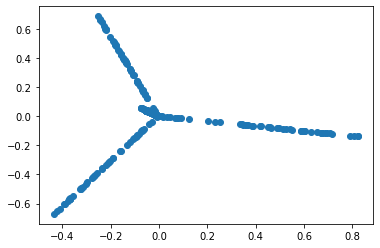

In [3]:
from sklearn.preprocessing import StandardScaler # for data standardization
from sklearn.decomposition import PCA # for PCA analysis
from sklearn import datasets

X_pca = PCA(n_components=2).fit_transform(X)
plt.scatter(X_pca[:, 0],X_pca[:,1])

In [12]:
from dr_visualization import plotly_2D_scatter
fig = plotly_2D_scatter(X_pca, y = np.ones(X.shape[0]), 
                        save_path="images/Tendril/PCA.pdf",
                  width=400, height=400, 
                  autosize=False, margin = {'l':0,'r':0,'t':0,'b':0})
fig.show()

Only see 4 clear tendrils.

## PH

In [5]:
from PH_projection_pursuit import bottleneck_proj_pursuit, subsample_bats
Y, inds, dHY = subsample_bats(X, k = 100)
P, opt_info = bottleneck_proj_pursuit(Y, opt_dim = 0, 
                                      optimizer_iter=10, scheduler_iter=20)

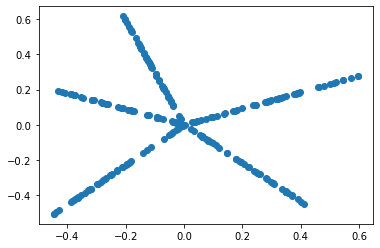

In [6]:
X_PH = X @ P.T
plt.scatter(X_PH[:, 0],X_PH[:,1])

Text(0.5, 1.0, 'learning rate')

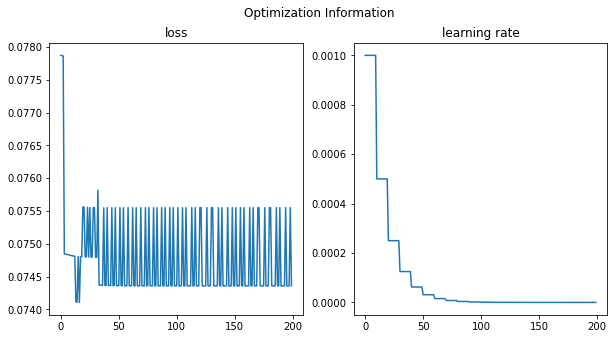

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
fig.suptitle('Optimization Information')
ax1.plot(opt_info['losses'])
ax1.set_title('loss')
ax2.plot(opt_info['lrs'])
ax2.set_title('learning rate')

Able to see 5

In [8]:
fig = plotly_2D_scatter(X_PH, y = np.ones(X.shape[0]), 
                        save_path="images/Tendril/PH.pdf",
                  width=400, height=400, 
                  autosize=False, margin = {'l':0,'r':0,'t':0,'b':0})
fig.show()

## Isomap

In [9]:
from sklearn.manifold import Isomap # for Isomap dimensionality reduction
### Step 1 - Configure the Isomap function, note we use default hyperparameter values in this example
embed = Isomap(
    n_neighbors=5, # default=5, algorithm finds local structures based on the nearest neighbors
    n_components=2, # number of dimensions
    eigen_solver='auto', # {‘auto’, ‘arpack’, ‘dense’}, default=’auto’
    tol=0, # default=0, Convergence tolerance passed to arpack or lobpcg. not used if eigen_solver == ‘dense’.
    max_iter=None, # default=None, Maximum number of iterations for the arpack solver. not used if eigen_solver == ‘dense’.
    path_method='auto', # {‘auto’, ‘FW’, ‘D’}, default=’auto’, Method to use in finding shortest path.
    neighbors_algorithm='auto', # neighbors_algorithm{‘auto’, ‘brute’, ‘kd_tree’, ‘ball_tree’}, default=’auto’
    n_jobs=-1, # n_jobsint or None, default=None, The number of parallel jobs to run. -1 means using all processors
    metric='minkowski', # string, or callable, default=”minkowski”
    p=2, # default=2, Parameter for the Minkowski metric. When p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance (l2) for p = 2
    metric_params=None # default=None, Additional keyword arguments for the metric function.
)

### Step 2 - Fit the data and transform it, so we have 3 dimensions instead of 64
X_isomap = embed.fit_transform(X)

X_isomap.shape

/home/ubuntu/miniconda3/envs/bats/lib/python3.9/site-packages/scikit_learn-1.0.2-py3.9-linux-x86_64.egg/sklearn/manifold/_isomap.py:324: UserWarning:

The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.

/home/ubuntu/miniconda3/envs/bats/lib/python3.9/site-packages/scipy-1.8.0rc2-py3.9-linux-x86_64.egg/scipy/sparse/_index.py:103: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/home/ubuntu/miniconda3/envs/bats/lib/python3.9/site-packages/scipy-1.8.0rc2-py3.9-linux-x86_64.egg/scipy/sparse/_index.py:103: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/home/ubuntu/miniconda3/envs/bats/lib/python3.9/site-packages/scipy-1.8.0rc2-py3.9-linux-x86_64.egg/scipy/sparse/_index.py:103: SparseEfficiencyWarning:

Changing the sparsity struct

(250, 2)

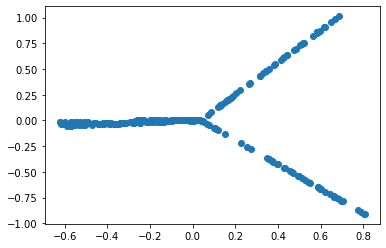

In [10]:
plt.scatter(X_isomap[:, 0],X_isomap[:,1])

In [11]:
fig = plotly_2D_scatter(X_isomap, y = np.ones(X.shape[0]), 
                        save_path="images/Tendril/ISOMAP.pdf",
                  width=400, height=400, 
                  autosize=False, margin = {'l':0,'r':0,'t':0,'b':0})
fig.show()

see 4 

## PH

In [7]:
from herabottleneck import BottleneckDistanceHera, BottleneckLayerHera
from torch_tda.nn import RipsLayer, Rips0Layer, BottleneckLayer, WassersteinLayer, BarcodePolyFeature
import bats
import torch

X.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

double check `C_CONTIGUOUS == True` so that BATs will run successfully.

### Rips

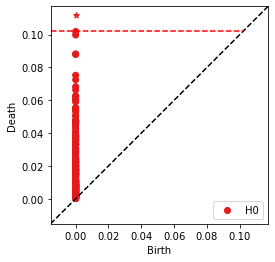

In [8]:
# see the ground truch PH information first
F = bats.LightRipsFiltration(bats.DataSet(bats.Matrix(X)), bats.Euclidean(), np.inf, 2)
R = bats.reduce(F, bats.F2(), bats.standard_reduction_flag(), bats.clearing_flag())
# find persistence pairs at each dimension
ps = []
for d in range(R.maxdim()):
    ps.extend(R.persistence_pairs(d))

# Draw persistent diagram
# 'tmax' is the axis maixmum value
fig, ax = bats.persistence_diagram(ps)

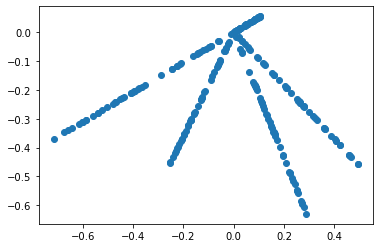

In [19]:
Xt = torch.tensor(X, dtype=torch.double)
n,p = Xt.shape
rand_mat = np.random.randn(p,2) 
V, _ = np.linalg.qr(rand_mat) # a random orthonormal projection
X_p = X @ V
plt.scatter(X_p[:, 0],X_p[:,1])

In [20]:
import time
layer = RipsLayer(maxdim=1, reduction_flags=(bats.standard_reduction_flag(), 
                                             bats.clearing_flag(),))
# layer = Rips0Layer()
ground_truth_dgm = layer(Xt)
crit = BottleneckLayer()
# crit = BottleneckLayerHera()

Vt = torch.tensor(V, dtype=torch.double, requires_grad = True)
optimizer = torch.optim.SGD([Vt], lr=1e-1, momentum=0.01)
losses = []

for i in range(101):
    ts = []
    optimizer.zero_grad()
    
    ts.append(time.monotonic())
    Y_dgm = layer(torch.mm(Xt, Vt))
#     loss = crit(Y_dgm[1], ground_truth_dgm[1]) + crit(Y_dgm[0], ground_truth_dgm[0])
    loss = crit(Y_dgm[0], ground_truth_dgm[0])
    if i%10 == 0:
        print(f"at iter {i} loss = {loss.item()}")
        
    loss.backward()
    ts.append(time.monotonic())
    optimizer.step()
    ts.append(time.monotonic())
    losses.append(loss.detach().numpy())

at iter 0 loss = 0.01359973878789579
at iter 10 loss = 0.013089070228385267
at iter 20 loss = 0.012577885320482925
at iter 30 loss = 0.012066700412580594
at iter 40 loss = 0.011555515504678267
at iter 50 loss = 0.011044330596775936
at iter 60 loss = 0.010533145688873598
at iter 70 loss = 0.010021960780971256
at iter 80 loss = 0.009678674027381033
at iter 90 loss = 0.0096737401492758
at iter 100 loss = 0.009668806272014423


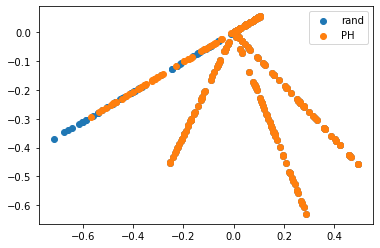

In [22]:
X_PH = X @ Vt.detach().numpy()
Xp = X @ V
# plt.scatter(X[:,0], X[:,1], label="true")
plt.scatter(Xp[:,0], Xp[:,1], label="rand")
plt.scatter(X_PH[:,0], X_PH[:,1], label="PH")
plt.legend()

Does not change too much